# Sigmoid Approximation
> __Purpose__: The goal of this notebook is to set the stage for procedurally generating neural networks, specifically by approximating the steady state values using sigmoid functions, instead of relying on experimentally determined alpha and beta functions.  This serves to reduce the number of parameters required needed to generate another neuron, and also to limit the function space we are working in (i.e. we are saying that all steady state values must follow some sigmoid function, as opposed to any arbitrary function).

In [1]:
from scipy.integrate import odeint, solve_ivp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

COLOR = 'grey'
mpl.rcParams['text.color'] = COLOR
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR

## Functions From NB 10 For Reference

In [2]:
def odes(x0,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations
    
    Params:: 
        x0: ICs for V,n,m,h
        t: time vector, not called in func but regardless
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function
        
    Returns:: Differential equations of each variable as a vector
    '''
    
    #set ICs
    V = x0[0]
    n = x0[1]
    m = x0[2]
    h = x0[3]
    
    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa = gbarNa*(m**3)*h
    gbarK = 0.36 #mS/cm2
    gK = gbarK*(n**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL
    
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    #membrane capacitance
    Cm = 0.01 #uF/cm^2
    #Alpha and beta forms
    alpha_n = 0.01*(V+50)/(1-np.exp(-(V+50)/10))
    beta_n = 0.125*np.exp(-(V+60)/80)
    alpha_m = 0.1*(V+35)/(1-np.exp(-(V+35)/10))
    beta_m = 4.0*np.exp(-0.0556*(V+60))
    alpha_h = 0.07*np.exp(-0.05*(V+60))
    beta_h = 1/(1+np.exp(-0.1*(V+30)))

    #define each ODE
    dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    dndt = alpha_n*(1-n)-beta_n*n
    dmdt = alpha_m*(1-m)-beta_m*m
    dhdt = alpha_h*(1-h)-beta_h*h
    
    return dVdt, dndt, dmdt, dhdt

In [3]:
def odes_scn(x0,t,I,vI_scn):
    '''
    Defines the constants and differential equations for the HH-compliant synaptically coupled neurons.
    
    Params:: 
        x0: ICs for V1,n1,m1,h1,s1,V2,n2,m2,h2,s2
        t: time vector, not sure if this is actually needed (not called in func)
        I: custom function, time varying current (square wave)
        vI_scn: custom 5x1 vector for I function, just encapsulates the parameters needed for I to function.  
          Also encapsulates the values for g1 and g2
        
    Returns:: Differential equations of each variable as a vector
    
    '''
        
    #set ICs
    V1 = x0[0]
    n1 = x0[1]
    m1 = x0[2]
    h1 = x0[3]
    s1 = x0[4]
    
    V2 = x0[5]
    n2 = x0[6]
    m2 = x0[7]
    h2 = x0[8]
    s2 = x0[9]
        
    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa1 = gbarNa*(m1**3)*h1
    gNa2 = gbarNa*(m2**3)*h2
    gbarK = 0.36 #mS/cm2
    gK1 = gbarK*(n1**4)
    gK2 = gbarK*(n2**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL
    
    #Passing g1/g2 through vI might not be the best approach...
    gbars1 = vI_scn[3]
    gs1 = gbars1*s1
    gbars2 = vI_scn[4]
    gs2 = gbars2*s2
    
    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -49.42 #mV
    ES1 = 0 #ENa #mV #Excitatory Neuron (by this definition)
    ES2 = ES1
    #membrane capacitance
    Cm = 0.01 #uF/cm^2
        
    #NEURON1
    #Alpha and beta forms
    alpha_n1 = 0.01*(V1+50)/(1-np.exp(-(V1+50)/10))
    beta_n1 = 0.125*np.exp(-(V1+60)/80)
    alpha_m1 = 0.1*(V1+35)/(1-np.exp(-(V1+35)/10))
    beta_m1 = 4.0*np.exp(-0.0556*(V1+60))
    alpha_h1 = 0.07*np.exp(-0.05*(V1+60))
    beta_h1 = 1/(1+np.exp(-0.1*(V1+30)))
    #define each ODE                                        #NOTE: USE G OF S2 HERE, FOR EQN V1
    dV1dt = (1/Cm)*(gNa1*(ENa-V1) + gK1*(EK-V1) + gL*(EL-V1) + gs2*(ES2-V1) + I(t,vI_scn)) 
    dn1dt = alpha_n1*(1-n1)-beta_n1*n1
    dm1dt = alpha_m1*(1-m1)-beta_m1*m1
    dh1dt = alpha_h1*(1-h1)-beta_h1*h1
    
    #NEURON2
    #Alpha and beta forms
    alpha_n2 = 0.01*(V2+50)/(1-np.exp(-(V2+50)/10))
    beta_n2 = 0.125*np.exp(-(V2+60)/80)
    alpha_m2 = 0.1*(V2+35)/(1-np.exp(-(V2+35)/10))
    beta_m2 = 4.0*np.exp(-0.0556*(V2+60))
    alpha_h2 = 0.07*np.exp(-0.05*(V2+60))
    beta_h2 = 1/(1+np.exp(-0.1*(V2+30)))
    #define each ODE                                     #NOTE: USE G OF S1 HERE, FOR EQN V2
    dV2dt = (1/Cm)*(gNa2*(ENa-V2) + gK2*(EK-V2) + gL*(EL-V2) + gs1*(ES1-V2) + I(t,vI_scn)*0  )
    #^Set the applied current to neuron 2 to 0 so that only neuron 1 is spiking initially
    dn2dt = alpha_n2*(1-n2)-beta_n2*n2
    dm2dt = alpha_m2*(1-m2)-beta_m2*m2
    dh2dt = alpha_h2*(1-h2)-beta_h2*h2 
        
    #s VARIABLE --> The actual synaptic coupling
    tau_s = 30 #10 #msec #--> Change made to extend the excitation period
    s_inf = 10.0/11.0  #arbitrary, just want it near 1
    alpha_s1 = (V1>0)*(1/tau_s) #(V1>0)*(10/tau_s) --> Ie change made to lower the rise time
    alpha_s2 = (V2>0)*(1/tau_s) #(V2>0)*(10/tau_s) --> Ie change made to lower the rise time
    beta_s = 1/tau_s
    ds1dt = alpha_s1*(1-s1)-beta_s*s1 
    ds2dt = alpha_s2*(1-s2)-beta_s*s2 
        
    return dV1dt, dn1dt, dm1dt, dh1dt, ds1dt, dV2dt, dn2dt, dm2dt, dh2dt, ds2dt

In [4]:
def I(t=0,vI=[0,0,0]):
    '''
    Determines the applied current, with respect to the HH model.  By default makes a square wave
    '''
    
    #Applied current
    t_start = vI[0]
    t_end = vI[1]
    amplitude = vI[2]
    
    applied_current = (t>=t_start)*(t<=t_end)*amplitude
    #Ie if t is within range [t_start,t_end], we apply some amount of current, amplitude
    #Recall: t>=C evaluates to a Boolean, which, when used numerically, is equivalent to 0 or 1
    return applied_current

In [5]:
def plot_vnmh(x,t,vertIndex=-1,gatingVars=False):
    '''
    Callable function for plotting V,n,m,h
    
    Params:
        x: Matrix, each column is one of the above variables
        t: Time vector for x axis
    '''
    
    #plot the results
    plt.figure(figsize=(15,10))
    #Font sizes
    title_font = 20
    label_font = 15

    #Trying to stop them overlapping:
    #fig, ax = plt.subplots(2,1) #--> fig overwrites so I am no longer working on the subplots
    #fig.tight_layout(h_pad=2)
    #fig.suptitle('Overall Title')
    
    #Extract variables from matrix
    if x.shape[1] == 4:
        V = x[:,0]
        n = x[:,1]
        m = x[:,2]
        h = x[:,3]
        
        plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V)
        
        if gatingVars:
            plt.subplot(212)
            plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
            plt.ylabel("Volts (mV)", fontsize=label_font)
            plt.xlabel("Time (ms)", fontsize=label_font)
            plt.plot(t,n,label="n")
            plt.plot(t,m,label="m")
            plt.plot(t,h,label="h")
            leg = plt.legend(loc='upper right')
            for text in leg.get_texts():
                text.set_color('black')
            plt.show()
        
    elif x.shape[0] == 10:
        V1 = x[0]
        n1 = x[1]
        m1 = x[2]
        h1 = x[3]
        s1 = x[4]
        V2 = x[5]
        n2 = x[6]
        m2 = x[7]
        h2 = x[8]
        s2 = x[9]
            
        plt.subplot(211)
        plt.title("Voltage as a Function of Time", fontsize=title_font, fontweight="bold")
        plt.ylabel("Volts (mV)", fontsize=label_font)
        plt.xlabel("Time (ms)", fontsize=label_font)
        plt.plot(t,V1,label="Neuron 1")
        plt.plot(t,V2,label="Neuron 2")
        if (vertIndex < 0):
            pass
        else:
            plt.axvline(x = vertIndex, color = 'r', label = 'Index Above Threshold')
        leg = plt.legend(loc='upper right')
        for text in leg.get_texts():
            text.set_color('black')
        plt.show()
        
        if gatingVars:
            plt.subplot(212)
            plt.title("Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
            plt.ylabel("Volts (mV)", fontsize=label_font)
            plt.xlabel("Time (ms)", fontsize=label_font)
            plt.plot(t,n1,label="n1")
            plt.plot(t,m1,label="m1")
            plt.plot(t,h1,label="h1")
            plt.plot(t,n2,label="n2")
            plt.plot(t,m2,label="m2")
            plt.plot(t,h2,label="h2")
            leg = plt.legend(loc='upper right')
            for text in leg.get_texts():
                text.set_color('black')
            plt.show()

In [6]:
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6]
#time vector
t = np.linspace(0,50,2000) #600
#vector needed 
vI = [0,0,0]

x = odeint(odes,x0,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

x0_new = x[-1,:]

#BURNED IN initial condition
vI = [5,7,0.1]
t = np.linspace(0,15,1000)
x = odeint(odes,x0_new,t,args=(I,vI))

V = x[:,0]
n = x[:,1]
m = x[:,2]
h = x[:,3]

## Finding the best approximation for sigmoid functions

In [7]:
#set ICs
x0 = [-58, 0.05, 0.33, 0.6]
V = x0[0]
n = x0[1]
m = x0[2]
h = x0[3]

#Constants
#Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
#conductances (S is Siemens)
gbarNa = 1.2 #mS/cm2
gNa = gbarNa*(m**3)*h
gbarK = 0.36 #mS/cm2
gK = gbarK*(n**4)
gbarL = 0.003 #mS/cm2
gL = gbarL

#reversal potentials
ENa = 55.17 #mV
EK = -72.14 #mV
EL = -49.42 #mV
#membrane capacitance
Cm = 0.01 #uF/cm^2

###########################################################################################

numPoints = 80
vRange = np.linspace(-80,60,numPoints)

n_inf = [0] * numPoints
m_inf = [0] * numPoints
h_inf = [0] * numPoints
n_infSIG = [0] * numPoints
m_infSIG = [0] * numPoints
h_infSIG = [0] * numPoints

tau_n = [0] * numPoints
tau_m = [0] * numPoints
tau_h = [0] * numPoints

for idx, V in enumerate(vRange):
    
    #Previous way, want to match this
    alpha_n = 0.01*(V+50)/(1-np.exp(-(V+50)/10))
    beta_n = 0.125*np.exp(-(V+60)/80)
    alpha_m = 0.1*(V+35)/(1-np.exp(-(V+35)/10))
    beta_m = 4.0*np.exp(-0.0556*(V+60))
    alpha_h = 0.07*np.exp(-0.05*(V+60))
    beta_h = 1/(1+np.exp(-0.1*(V+30)))

    n_inf[idx] = alpha_n / (alpha_n + beta_n)
    m_inf[idx] = alpha_m / (alpha_m + beta_m)
    h_inf[idx] = alpha_h / (alpha_h + beta_h)
    
    tau_n[idx] = 1 / (alpha_n + beta_n)
    tau_m[idx] = 1 / (alpha_m + beta_m)
    tau_h[idx] = 1 / (alpha_h + beta_h)

    ###########################################################################################

    #New way, manipulate sigma such that it matches the above
    #V0: Manipulates the x location placement
    V0n = -49; V0m = -36; V0h = -55
    #Sigma: Manipulates the steepness, bigger sigma means less steep step
    sign = 18; sigm = 10; sigh = -8

    n_infSIG[idx] = 1 / (1 + np.exp(-(V-V0n)/sign))
    m_infSIG[idx] = 1 / (1 + np.exp(-(V-V0m)/sigm))
    h_infSIG[idx] = 1 / (1 + np.exp(-(V-V0h)/sigh))

    tau_nSIG = 2
    tau_mSIG = 0.1
    tau_hSIG = 2

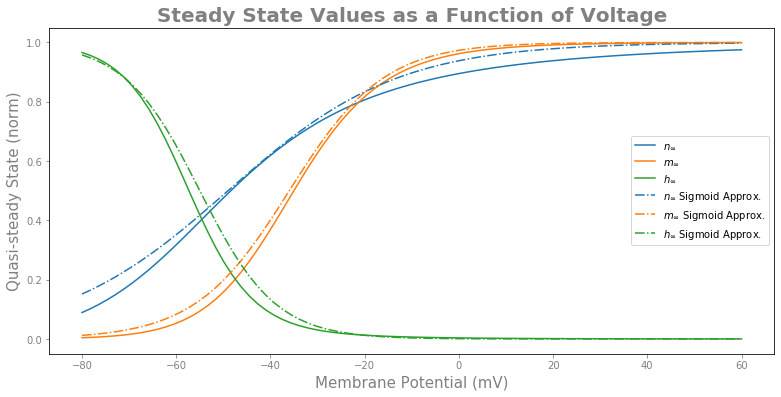

In [8]:
#Font sizes
title_font = 20
label_font = 15
colors_arr = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
dashed1 = '-.'

plt.figure(figsize=(13,6))
plt.title("Steady State Values as a Function of Voltage", fontsize=title_font, fontweight="bold")
plt.ylabel("Quasi-steady State (norm)", fontsize=label_font)
plt.xlabel("Membrane Potential (mV)", fontsize=label_font)
plt.plot(vRange,n_inf,label=r"$n_\infty$",color=colors_arr[0])
plt.plot(vRange,m_inf,label=r"$m_\infty$",color=colors_arr[1])
plt.plot(vRange,h_inf,label=r"$h_\infty$",color=colors_arr[2])

plt.plot(vRange,n_infSIG,dashed1,label=r"$n_\infty$ Sigmoid Approx.",color=colors_arr[0])
plt.plot(vRange,m_infSIG,dashed1,label=r"$m_\infty$ Sigmoid Approx.",color=colors_arr[1])
plt.plot(vRange,h_infSIG,dashed1,label=r"$h_\infty$ Sigmoid Approx.",color=colors_arr[2])
leg = plt.legend(loc='center right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()

## Plotting time constants of original HH model
> Note that the time constants (which are essentially rates, should we invert them to have 1/s) are not sigmoid functions.  We will not try to use sigmoid functions, but instead see if we can recreate the neuronal activity using a constant time constant value.  If not we will switch to some kind of function.

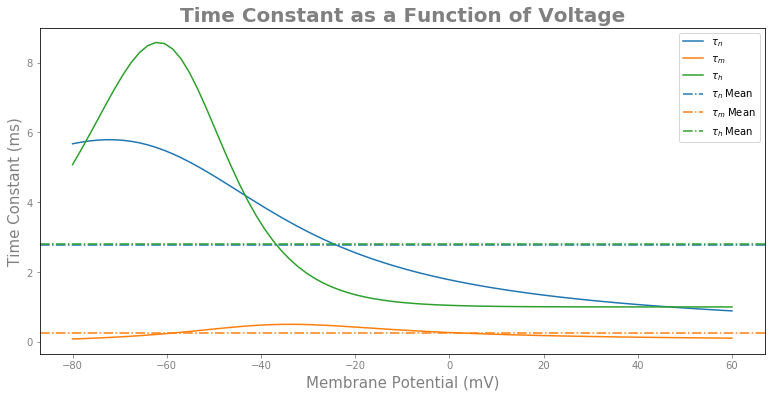

In [9]:
#Font sizes
title_font = 20
label_font = 15
colors_arr = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
dashed1 = '-.'

tau_n_mean = np.mean(tau_n)
tau_m_mean = np.mean(tau_m)
tau_h_mean = np.mean(tau_h)

plt.figure(figsize=(13,6))
plt.title("Time Constant as a Function of Voltage", fontsize=title_font, fontweight="bold")
plt.ylabel("Time Constant (ms)", fontsize=label_font)
plt.xlabel("Membrane Potential (mV)", fontsize=label_font)
plt.plot(vRange,tau_n,label=r"$\tau_n$",color=colors_arr[0])
plt.plot(vRange,tau_m,label=r"$\tau_m$",color=colors_arr[1])
plt.plot(vRange,tau_h,label=r"$\tau_h$",color=colors_arr[2])

plt.axhline(y = tau_n_mean,color=colors_arr[0],linestyle=dashed1,label=r"$\tau_n$ Mean")
plt.axhline(y = tau_m_mean,color=colors_arr[1],linestyle=dashed1,label=r"$\tau_m$ Mean")
plt.axhline(y = tau_h_mean,color=colors_arr[2],linestyle=dashed1,label=r"$\tau_h$ Mean")

leg = plt.legend(loc='upper right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()

## Comparing Original HH to Sigmoid Approx
1. Original HH, using odes from NB 10

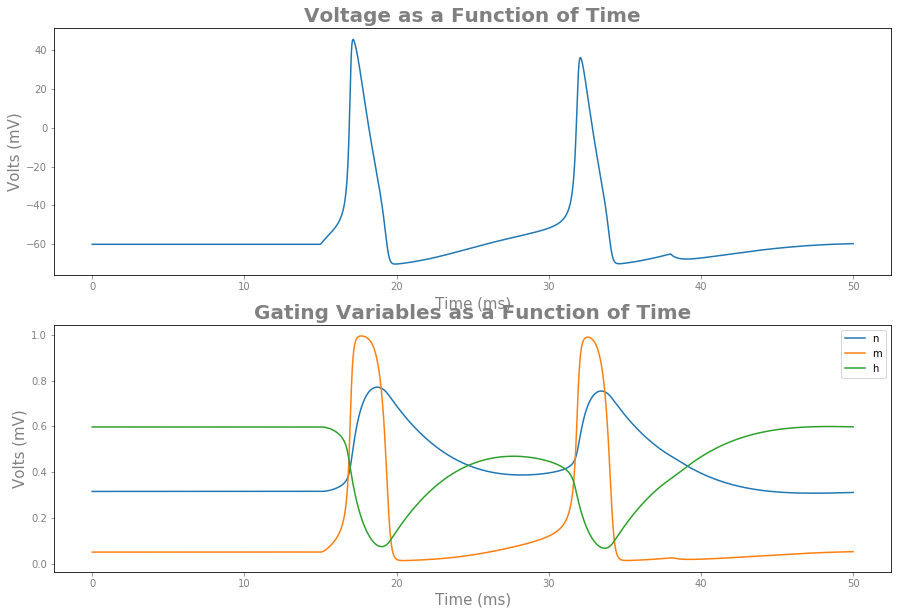

In [31]:
#print("Burn in run")
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6]
#time vector
t = np.linspace(0,50,2000) #600

xHH_BI = odeint(odes,x0,t,args=(I,[0,0,0]))
x = xHH_BI
#plot_vnmh(x,t,gatingVars=True)
x0_new = x[-1,:]

#print("Actual run, 0.1 A @ 5 ms")
#BURNED IN initial condition
t = np.linspace(0,50,2000)
xHH_Final = odeint(odes,x0_new,t,args=(I,[15,38,0.1]))
x = xHH_Final
plot_vnmh(x,t,gatingVars=True)

2. Using sigmoid approximations

In [32]:
def odes_sigmoid(x0,t,I,vI):
    '''
    Defines the constants and differential equations for the base Hodgkin-Huxley equations

    Params:: 
        x0: ICs for V,n,m,h
        t: time vector, not called in func but regardless
        I: custom function, time varying current (square wave)
        vI: custom 3x1 vector for I function, just encapsulates the parameters needed for I to function

    Returns:: Differential equations of each variable as a vector
    '''

    #set ICs
    V = x0[0]
    n = x0[1]
    m = x0[2]
    h = x0[3]

    #Constants
    #Source: https://www.math.mcgill.ca/gantumur/docs/reps/RyanSicilianoHH.pdf
    #conductances (S is Siemens)
    gbarNa = 1.2 #mS/cm2
    gNa = gbarNa*(m**3)*h
    gbarK = 0.36 #mS/cm2
    gK = gbarK*(n**4)
    gbarL = 0.003 #mS/cm2
    gL = gbarL

    #reversal potentials
    ENa = 55.17 #mV
    EK = -72.14 #mV
    EL = -57.99 #-49.42 #mV
    #membrane capacitance
    Cm = 0.01 #uF/cm^2

    ###########################################################################################

    #New way, manipulate sigma such that it matches the above
    #V0: Manipulates the x location placement
    V0n = -49; V0m = -36; V0h = -55
    #Sigma: Manipulates the steepness, bigger sigma means less steep step
    sign = 18; sigm = 10; sigh = -8

    n_inf = 1 / (1 + np.exp(-(V-V0n)/sign))
    m_inf = 1 / (1 + np.exp(-(V-V0m)/sigm))
    h_inf = 1 / (1 + np.exp(-(V-V0h)/sigh))

    tau_n = tau_n_mean #2.785
    tau_m = tau_m_mean #0.258
    tau_h = tau_h_mean #2.810

    #define each ODE
    dVdt = (1/Cm)*(gNa*(ENa-V) + gK*(EK-V) + gL*(EL-V) + I(t,vI))
    dndt = (1/tau_n)*(n_inf - n)
    dmdt = (1/tau_m)*(m_inf - m)
    dhdt = (1/tau_h)*(h_inf - h)

    return dVdt, dndt, dmdt, dhdt

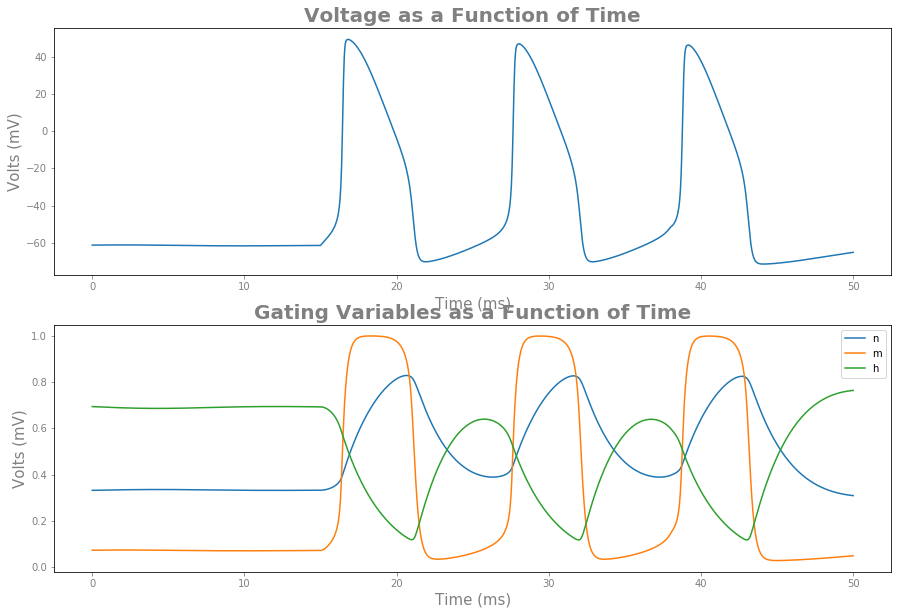

In [33]:
#print("Burn in run, looking for NO oscillations")
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6]
#time vector
t = np.linspace(0,50,2000)

xSIG_BI = odeint(odes_sigmoid,x0,t,args=(I,[0,0,0]))
x = xSIG_BI
#plot_vnmh(x,t,gatingVars=True)

x0_new = x[-1,:]
#print("-----------------------------------------------------------------------------------")

#print("Actual run, using a current of 0.1 A @ 5 ms.  No oscillations expected")
#BURNED IN initial condition
#vI = [5,7,0.1]
xSIG_Final = odeint(odes_sigmoid,x0_new,t,args=(I,[15,38,0.1]))
x = xSIG_Final
plot_vnmh(x,t,gatingVars=True)
x0_2 = x[-1,:]

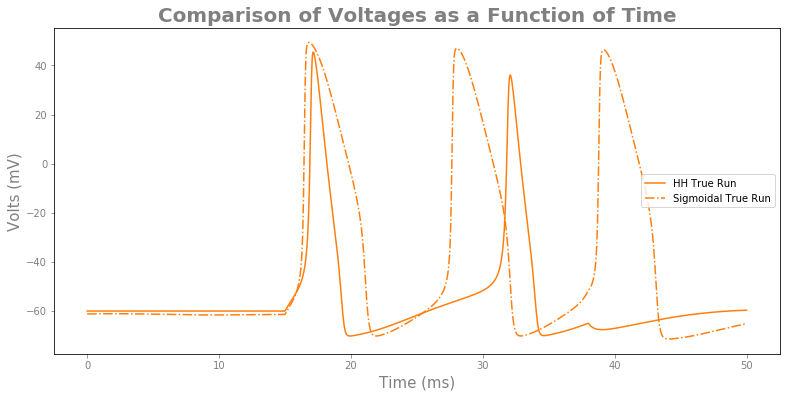

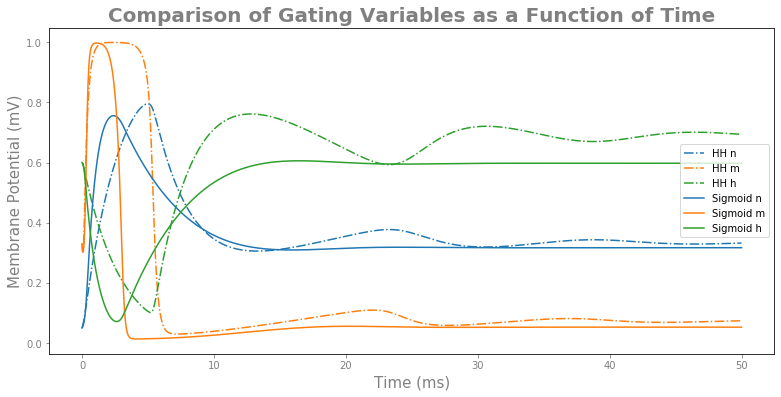

In [34]:
VHH_BI = xHH_BI[:,0]
nHH_BI = xHH_BI[:,1]
mHH_BI = xHH_BI[:,2]
hHH_BI = xHH_BI[:,3]
VHH_Final = xHH_Final[:,0]
nHH_Final = xHH_Final[:,1]
mHH_Final = xHH_Final[:,2]
hHH_Final = xHH_Final[:,3]
##############################
VSIG_BI = xSIG_BI[:,0]
nSIG_BI = xSIG_BI[:,1]
mSIG_BI = xSIG_BI[:,2]
hSIG_BI = xSIG_BI[:,3]
VSIG_Final = xSIG_Final[:,0]
nSIG_Final = xSIG_Final[:,1]
mSIG_Final = xSIG_Final[:,2]
hSIG_Final = xSIG_Final[:,3]
##############################
#Font sizes
title_font = 20
label_font = 15
colors_arr = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
dashed1 = '-.'
##################################################
plt.figure(figsize=(13,6))
plt.title("Comparison of Voltages as a Function of Time", fontsize=title_font, fontweight="bold")
plt.xlabel("Time (ms)", fontsize=label_font)
plt.ylabel("Volts (mV)", fontsize=label_font)
plt.plot(t,VHH_Final,label="HH True Run",color=colors_arr[1])

plt.plot(t,VSIG_Final,dashed1,label="Sigmoidal True Run",color=colors_arr[1])

leg = plt.legend(loc='center right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()
##################################################
plt.figure(figsize=(13,6))
plt.title("Comparison of Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
plt.xlabel("Time (ms)", fontsize=label_font)
plt.ylabel("Membrane Potential (mV)", fontsize=label_font)
plt.plot(t,nSIG_BI,dashed1,label="HH n",color=colors_arr[0])
plt.plot(t,mSIG_BI,dashed1,label="HH m",color=colors_arr[1])
plt.plot(t,hSIG_BI,dashed1,label="HH h",color=colors_arr[2])

plt.plot(t,nHH_BI,label="Sigmoid n",color=colors_arr[0])
plt.plot(t,mHH_BI,label="Sigmoid m",color=colors_arr[1])
plt.plot(t,hHH_BI,label="Sigmoid h",color=colors_arr[2])

leg = plt.legend(loc='center right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()

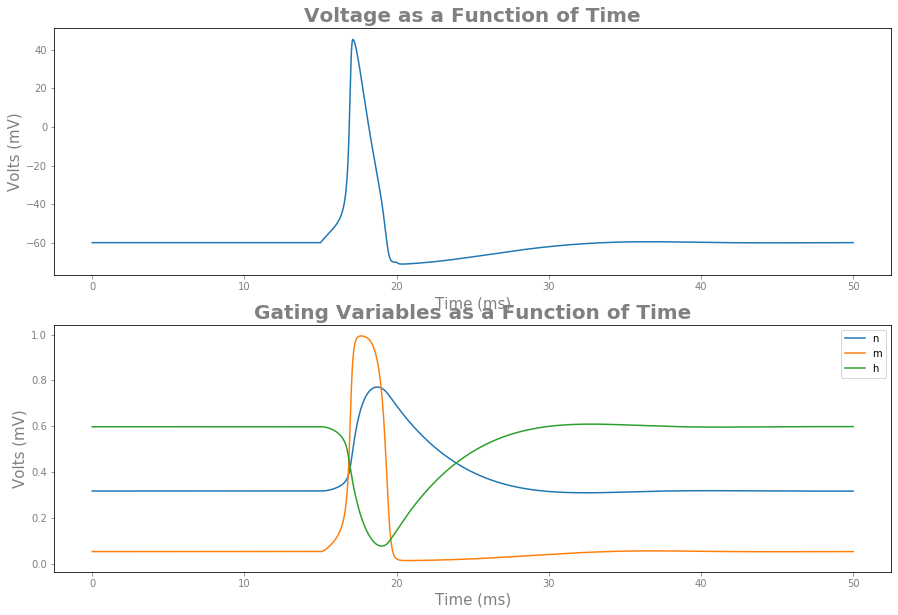

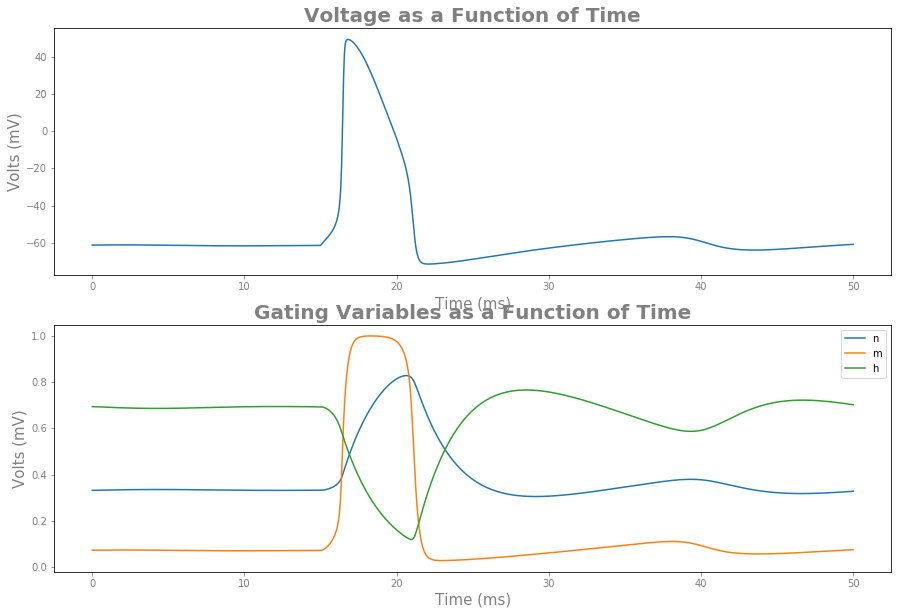

In [38]:
#print("Burn in run")
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6]
#time vector
t = np.linspace(0,50,2000) #600

xHH_BI = odeint(odes,x0,t,args=(I,[0,0,0]))
x = xHH_BI
#plot_vnmh(x,t,gatingVars=True)
x0_new = x[-1,:]

#print("Actual run, 0.1 A @ 5 ms")
#BURNED IN initial condition
t = np.linspace(0,50,2000)
xHH_Final = odeint(odes,x0_new,t,args=(I,[15,20,0.1]))
x = xHH_Final
plot_vnmh(x,t,gatingVars=True)

#print("Burn in run, looking for NO oscillations")
#initial condition: V, n, m, h
x0 = [-58, 0.05, 0.33, 0.6]
#time vector
t = np.linspace(0,50,2000)

xSIG_BI = odeint(odes_sigmoid,x0,t,args=(I,[0,0,0]))
x = xSIG_BI
#plot_vnmh(x,t,gatingVars=True)

x0_new = x[-1,:]
#print("-----------------------------------------------------------------------------------")

#print("Actual run, using a current of 0.1 A @ 5 ms.  No oscillations expected")
#BURNED IN initial condition
#vI = [5,7,0.1]
xSIG_Final = odeint(odes_sigmoid,x0_new,t,args=(I,[15,20,0.1]))
x = xSIG_Final
plot_vnmh(x,t,gatingVars=True)
x0_2 = x[-1,:]

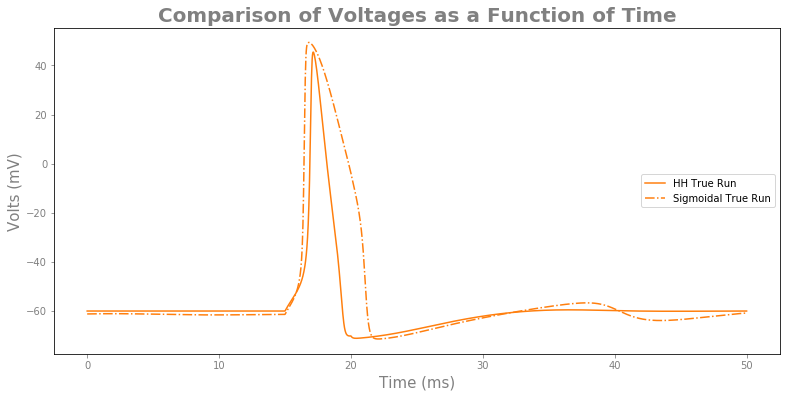

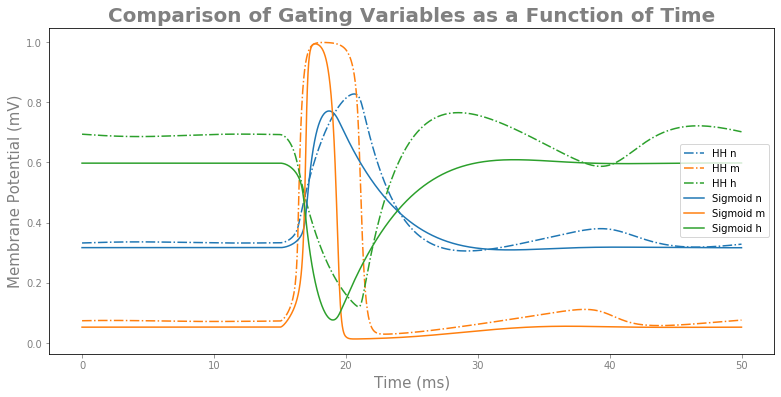

In [40]:
VHH_Final = xHH_Final[:,0]
nHH_Final = xHH_Final[:,1]
mHH_Final = xHH_Final[:,2]
hHH_Final = xHH_Final[:,3]
##############################
VSIG_Final = xSIG_Final[:,0]
nSIG_Final = xSIG_Final[:,1]
mSIG_Final = xSIG_Final[:,2]
hSIG_Final = xSIG_Final[:,3]
##############################
#Font sizes
title_font = 20
label_font = 15
colors_arr = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
dashed1 = '-.'
##################################################
plt.figure(figsize=(13,6))
plt.title("Comparison of Voltages as a Function of Time", fontsize=title_font, fontweight="bold")
plt.xlabel("Time (ms)", fontsize=label_font)
plt.ylabel("Volts (mV)", fontsize=label_font)
plt.plot(t,VHH_Final,label="HH True Run",color=colors_arr[1])

plt.plot(t,VSIG_Final,dashed1,label="Sigmoidal True Run",color=colors_arr[1])

leg = plt.legend(loc='center right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()
##################################################
plt.figure(figsize=(13,6))
plt.title("Comparison of Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
plt.xlabel("Time (ms)", fontsize=label_font)
plt.ylabel("Membrane Potential (mV)", fontsize=label_font)
plt.plot(t,nSIG_Final,dashed1,label="HH n",color=colors_arr[0])
plt.plot(t,mSIG_Final,dashed1,label="HH m",color=colors_arr[1])
plt.plot(t,hSIG_Final,dashed1,label="HH h",color=colors_arr[2])

plt.plot(t,nHH_Final,label="Sigmoid n",color=colors_arr[0])
plt.plot(t,mHH_Final,label="Sigmoid m",color=colors_arr[1])
plt.plot(t,hHH_Final,label="Sigmoid h",color=colors_arr[2])

leg = plt.legend(loc='center right')
for text in leg.get_texts():
    text.set_color('black')
plt.show()

Since a somewhat substantial change in EL was required, the following cells are investigating whether similar results can be achieved without such substantial changes, although changes will now be focused on the conductances as opposed to the reversal potentials.

## Finding best sigmoid approximation for s, the synaptic coupling variable
- As it's currently (hard-)coded, tau_s and s_inf are both constants, not sigmoids
- Thus, s is a constant (albeit could be a square wave), thus a single constant is essentially an approximation

## Various combinations that produce no oscilations in burn in, and furthermore have 
1. Lowering EL to -57.99 or lower
2. Lowering EL to -55, gNa to 1
3. Lowering gNa to 0.9
4. Raising gK to 0.46, lowering EL to -55
5. Rasing gK to 0.48
6. Raising gL to 0.048
7. Raising gL to 0.02, lowering EL to -55

## Making a clean subplot for poster:

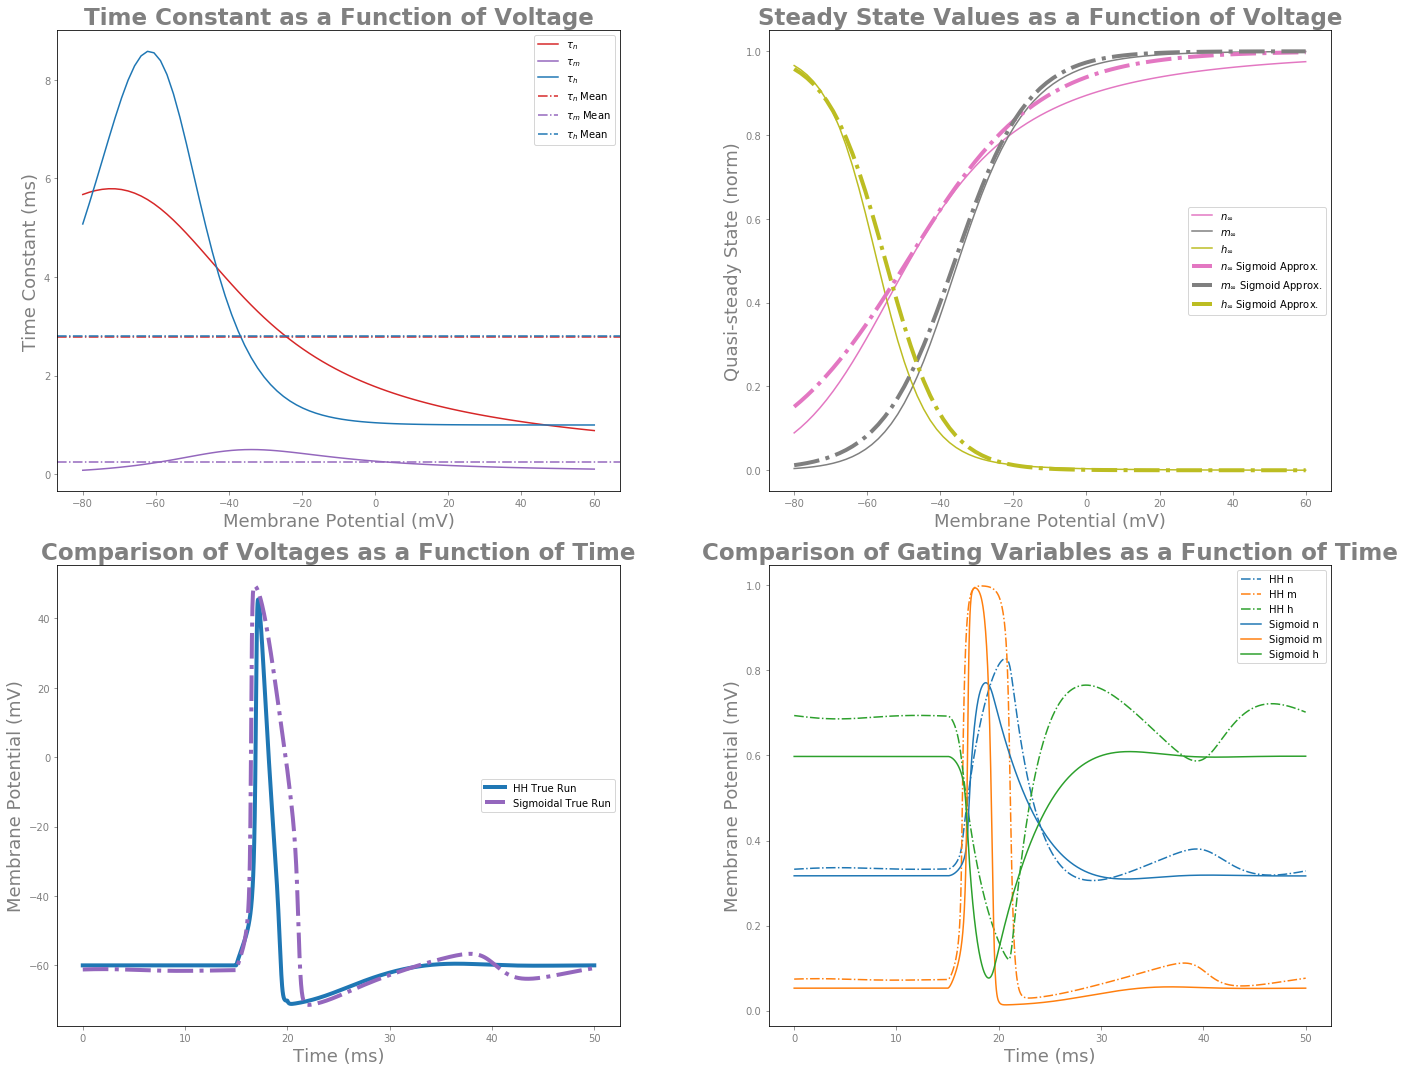

In [47]:
#Font sizes
title_font = 23
label_font = 18
colors_arr = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
dashed1 = '-.'
##############################
f = plt.figure(figsize=(20,15))
ax = f.add_subplot(223)
ax2 = f.add_subplot(224)
ax3 = f.add_subplot(221)
ax4 = f.add_subplot(222)
########################################################################################
ax.set_title("Comparison of Voltages as a Function of Time", fontsize=title_font, fontweight="bold")
ax.set_xlabel("Time (ms)", fontsize=label_font)
ax.set_ylabel("Membrane Potential (mV)", fontsize=label_font)
ax.plot(t,VHH_Final,label="HH True Run",color=colors_arr[0],linewidth=4)

ax.plot(t,VSIG_Final,dashed1,label="Sigmoidal True Run",color=colors_arr[4],linewidth=4)
leg = ax.legend(loc='center right')
for text in leg.get_texts():
    text.set_color('black')
########################################################################################
ax2.set_title("Comparison of Gating Variables as a Function of Time", fontsize=title_font, fontweight="bold")
ax2.set_xlabel("Time (ms)", fontsize=label_font)
ax2.set_ylabel("Membrane Potential (mV)", fontsize=label_font)
ax2.plot(t,nSIG_Final,dashed1,label="HH n",color=colors_arr[0])
ax2.plot(t,mSIG_Final,dashed1,label="HH m",color=colors_arr[1])
ax2.plot(t,hSIG_Final,dashed1,label="HH h",color=colors_arr[2])

ax2.plot(t,nHH_Final,label="Sigmoid n",color=colors_arr[0])
ax2.plot(t,mHH_Final,label="Sigmoid m",color=colors_arr[1])
ax2.plot(t,hHH_Final,label="Sigmoid h",color=colors_arr[2])
leg = ax2.legend(loc='upper right')
for text in leg.get_texts():
    text.set_color('black')
########################################################################################
tau_n_mean = np.mean(tau_n)
tau_m_mean = np.mean(tau_m)
tau_h_mean = np.mean(tau_h)

ax3.set_title("Time Constant as a Function of Voltage", fontsize=title_font, fontweight="bold")
ax3.set_ylabel("Time Constant (ms)", fontsize=label_font)
ax3.set_xlabel("Membrane Potential (mV)", fontsize=label_font)
ax3.plot(vRange,tau_n,label=r"$\tau_n$",color=colors_arr[3])
ax3.plot(vRange,tau_m,label=r"$\tau_m$",color=colors_arr[4])
ax3.plot(vRange,tau_h,label=r"$\tau_h$",color=colors_arr[0])

ax3.axhline(y = tau_n_mean,color=colors_arr[3],linestyle=dashed1,label=r"$\tau_n$ Mean")
ax3.axhline(y = tau_m_mean,color=colors_arr[4],linestyle=dashed1,label=r"$\tau_m$ Mean")
ax3.axhline(y = tau_h_mean,color=colors_arr[0],linestyle=dashed1,label=r"$\tau_h$ Mean")
leg = ax3.legend(loc='upper right')
for text in leg.get_texts():
    text.set_color('black')
########################################################################################
ax4.set_title("Steady State Values as a Function of Voltage", fontsize=title_font, fontweight="bold")
ax4.set_ylabel("Quasi-steady State (norm)", fontsize=label_font)
ax4.set_xlabel("Membrane Potential (mV)", fontsize=label_font)
ax4.plot(vRange,n_inf,label=r"$n_\infty$",color=colors_arr[6])
ax4.plot(vRange,m_inf,label=r"$m_\infty$",color=colors_arr[7])
ax4.plot(vRange,h_inf,label=r"$h_\infty$",color=colors_arr[8])

ax4.plot(vRange,n_infSIG,dashed1,label=r"$n_\infty$ Sigmoid Approx.",color=colors_arr[6],linewidth=4)
ax4.plot(vRange,m_infSIG,dashed1,label=r"$m_\infty$ Sigmoid Approx.",color=colors_arr[7],linewidth=4)
ax4.plot(vRange,h_infSIG,dashed1,label=r"$h_\infty$ Sigmoid Approx.",color=colors_arr[8],linewidth=4)
leg = ax4.legend(loc='center right')
for text in leg.get_texts():
    text.set_color('black')
plt.tight_layout()